<a href="https://colab.research.google.com/github/asamiei/mitoses_detection_/blob/main/Mitoses_Binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Takes in a 60 x 60 image (RGB), and determines if it is mitosis (=1) or not (=0) 
# The cell shoudl be at the center, with a radius of ~30 pixels

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import pickle
import pandas as pd


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
!pip install segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 7.7 MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
# Getting a list of images
normal_images = glob.glob("/content/gdrive/MyDrive/MITOS dataset/normal_images/*")

# Combining all the images into one numpy array
normal_images_dataset = np.array([np.array(np.load(fname)) for fname in normal_images])

# Storing/pickling
#normal_images_dataset.dump('/content/drive/MyDrive/MITOS dataset/normal_images_dataset.npy')

In [ ]:
np.shape(normal_images_dataset)

(924, 60, 60, 3)

In [ ]:
mitosis_images = glob.glob("/content/gdrive/MyDrive/MITOS dataset/mitoses_images/*")

# Combining all the images into one numpy array
mitosis_images_dataset = np.array([np.array(np.load(fname)) for fname in mitosis_images])

# Storing/pickling
#mitosis_images_dataset.dump('/content/drive/MyDrive/MITOS dataset/neuroendocrine_mitosis_images_dataset.npy')

In [ ]:
np.shape(mitosis_images_dataset)

(564, 60, 60, 3)

In [ ]:
# Combining normal and mitosis images
combined_image_dataset = np.concatenate((normal_images_dataset, mitosis_images_dataset), axis = 0)

In [ ]:
np.shape(combined_image_dataset)

(1488, 60, 60, 3)

In [ ]:
np.shape(combined_image_dataset[9])

(60, 60, 3)

In [ ]:
np.size(combined_image_dataset, axis = 0)

1488

In [ ]:
# Assigning a label to each image
    # 0 = Normal
    # 1 = Mitosis
normal_label = np.zeros(np.size(normal_images_dataset, axis = 0))
mitosis_label = np.ones(np.size(mitosis_images_dataset, axis = 0))

combined_label_dataset = np.concatenate((normal_label, mitosis_label), axis = 0)

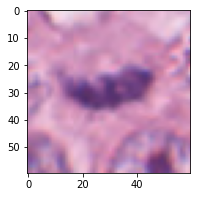

1.0

In [ ]:
plt.figure(figsize=(3,3))
img_ = cv2.cvtColor(combined_image_dataset[1001], cv2.COLOR_BGR2RGB)
plt.imshow(img_)
plt.show()
combined_label_dataset[1001]

In [ ]:
combined_label_dataset

array([0., 0., 0., ..., 1., 1., 1.])

In [ ]:
SIZE = 60

#Use customary x_train and y_train variables
X = combined_image_dataset
Y = combined_label_dataset


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))  


#Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
#But, also good for binary mutually exclusive (cat or not cat). 

model.compile(loss='binary_crossentropy',
              optimizer='adam',             
              metrics=['accuracy'])

#print(model.summary())     

##########################################################

history = model.fit(x_train, 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 100,      
                         validation_data=(x_val,y_val),
                         shuffle = True
                     )



Epoch 1/100
20/20 [==============================] - 19s 35ms/step - loss: 0.3685 - accuracy: 0.8449 - val_loss: 19.7508 - val_accuracy: 0.6205
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1496 - accuracy: 0.9533 - val_loss: 10.7301 - val_accuracy: 0.6205
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1122 - accuracy: 0.9691 - val_loss: 4.9393 - val_accuracy: 0.6205
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0842 - accuracy: 0.9802 - val_loss: 3.3602 - val_accuracy: 0.6205
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0719 - accuracy: 0.9826 - val_loss: 2.6287 - val_accuracy: 0.6384
Epoch 6/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0618 - accuracy: 0.9842 - val_loss: 1.2564 - val_accuracy: 0.7098
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0502 - accuracy: 0.9913 - val_loss: 0.9221 - val_accuracy: 0.7321
Epoch 8/1

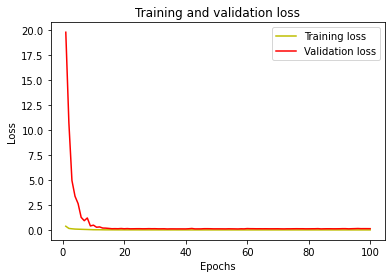

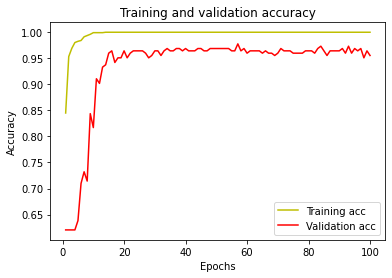

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/saved_models/simple_Mitoses_Binary_classification_Sept_22th.h5')  


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


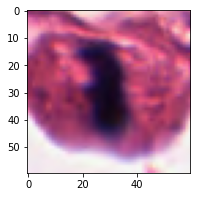

The prediction for this image is:  [[0.99986744]]
The actual label for this image is:  1.0
7/7 [==============================] - 0s 3ms/step - loss: 0.1241 - accuracy: 0.9554
Accuracy =  95.53571343421936 %
[[135   4]
 [  4  81]]


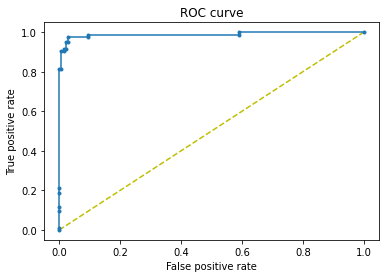

Ideal threshold is:  14    0.214343
Name: thresholds, dtype: float32
Area under curve, AUC =  0.9896741430385104


In [ ]:
n=149  #Select the index of image to be loaded for testing
img = (x_val[n]).astype(np.uint16)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()


input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_val[n])

################################################################

_, acc = model.evaluate(x_val, y_val)
print("Accuracy = ", (acc * 100.0), "%")



#Confusion matrix
mythreshold = 0.269967
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(x_val)>= mythreshold).astype(int)
cm = confusion_matrix(y_val, y_pred)  
print(cm)



#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(x_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_preds)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()



i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 


from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)